# EEE6504 - HW3 #
## Jackson Cornell ##

In [1]:
import math
import time
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

## Functions ##

In [2]:
# Gaussian kernel
def Kernel(x, kernel_size) :
    return np.exp(-x**2 / kernel_size**2)

In [3]:
# Vector quantization algorithm
def QV(C, err, threshold, embedding_size, sample, current_error) :
    # compute minimum distance
    minimum = 1e100
    min_index = 0
    if (len(C) != 0) :
        min_index = np.argmin(abs(sample[embedding_size-1] - np.array(C)[:,embedding_size-1]))
        minimum = abs(sample[embedding_size-1] - np.array(C)[min_index,embedding_size-1])
    # update codebook
    if (minimum > threshold) :
        C.append(sample)
        err.append(current_error)
    else :
        err[min_index] += current_error
    return C, err

In [4]:
# QKLMS filter with MSE cost function
def QKLMS_MSE(x, d, kernel_size, embedding_size, step_size, threshold) :
    # calculate epochs
    epochs = np.size(x)
    # initialize vectors
    x = np.concatenate((np.zeros(embedding_size), x))
    e = np.zeros(epochs)
    y = np.zeros(epochs)
    a = np.zeros(epochs)
    growth = np.zeros(epochs)
    C = []
    err = []
    for i in range(epochs) :
        # compute output
        y[i] = 0
        x_vect = np.array(x[i:(i+embedding_size)])
        if (i != 0) :
            y[i] = step_size * np.array(err[0:i]).T @ Kernel(np.linalg.norm(x_vect - np.array(C), 2, axis=1), kernel_size)
        # update error
        e[i] = d[i] - y[i]
        # compute QV
        C, err = QV(C, err, threshold, embedding_size, x_vect, e[i])
        # update growth
        growth[i] = len(C)
    # return weights and learning curve
    return e, y, growth, step_size*np.array(err)

In [5]:
# QKLMS filter with MCC cost function
def QKLMS_MCC(x, d, kernel_size, entropy_kernel_size, embedding_size, step_size, threshold) :
    # calculate epochs
    epochs = np.size(x)
    # initialize vectors
    x = np.concatenate((np.zeros(embedding_size), x))
    e = np.zeros(epochs)
    y = np.zeros(epochs)
    a = np.zeros(epochs)
    growth = np.zeros(epochs)
    C = []
    err = []
    for i in range(epochs) :
        # compute output
        y[i] = 0
        x_vect = np.array(x[i:(i+embedding_size)])
        if (i != 0) :
            y[i] = step_size * (np.array(err[0:i]) * Kernel(np.array(err[0:i]), entropy_kernel_size)).T @ Kernel(np.linalg.norm(x_vect - np.array(C), 2, axis=1), kernel_size) / entropy_kernel_size**2
        # update error
        e[i] = d[i] - y[i]
        # compute QV
        C, err = QV(C, err, threshold, embedding_size, x_vect, e[i])
        # update growth
        growth[i] = len(C)
    # return weights and learning curve
    return e, y, growth, step_size*np.array(err)

In [6]:
# KRLS filter with MSE cost function
def QKRLS_MSE(x, d, regularizer, kernel_size, embedding_size, threshold) :
    # calculate epochs
    epochs = np.size(x)
    # initialize vectors
    x = np.concatenate((np.zeros(embedding_size), x))
    e = np.zeros(epochs)
    y = np.zeros(epochs)
    growth = np.zeros(epochs)
    C = []
    a = []
    Q = 0
    # iterate through samples
    for i in range(epochs) :
        # run QKRLS
        x_vect = x[i:(i+embedding_size)]
        if (i == 0) :
            Q = np.array([regularizer + Kernel(0, kernel_size)])**-1
            a = np.array([Q*d[0]])
            y[0] = 0
            C.append(x_vect)
        else :
            # compute QV
            minimum = 1e100
            min_index = 0
            if (len(C) != 0) :
                min_index = np.argmin(abs(x_vect[embedding_size-1] - np.array(C)[:,embedding_size-1]))
                minimum = abs(x_vect[embedding_size-1] - np.array(C)[min_index,embedding_size-1])
            # update codebook
            if (minimum > threshold) :
                C.append(x_vect)
                h = np.array([Kernel(np.linalg.norm(x_vect - np.array(C[0:(len(C)-1)]), 2, axis=1), kernel_size)]).T
                quantized = 1
            else :
                h = np.array([Kernel(np.linalg.norm(x_vect - np.array(C[0:(len(C))]), 2, axis=1), kernel_size)]).T
                quantized = 0
            # compute vectors
            z = np.array(Q@h)
            r = regularizer + Kernel(0, kernel_size) - z.T@h
            # update error
            y[i] = h.T@np.array(a)
            e[i] = d[i] - y[i]
            # compute output if quantized
            if (quantized == 1) :
                # update Q matrix
                Q_dim = len(z) + 1
                Q_t = np.zeros((Q_dim, Q_dim))
                Q_t[0:(Q_dim-1), 0:(Q_dim-1)] = r*Q + z@z.T
                Q_t[0:(Q_dim-1), (Q_dim-1):Q_dim] = -z
                Q_t[(Q_dim-1):Q_dim, 0:(Q_dim-1)] = -z.T
                Q_t[(Q_dim-1):Q_dim, (Q_dim-1):Q_dim] = 1
                Q = Q_t / r
                # update weights
                a_t = np.zeros((Q_dim,1))
                a_t[0:(Q_dim-1)] = a - z*e[i] / r
                a_t[(Q_dim-1):Q_dim] = e[i] / r
                a = a_t
            else :
                a[min_index] += e[i]
        # update growth curve
        growth[i] = len(C)
    return e, y, growth, np.array(a)

In [7]:
# KRLS filter with MSE cost function
def QKRLS_MCC(x, d, regularizer, forgetting_factor, kernel_size, entropy_kernel_size, embedding_size, threshold) :
    # calculate epochs
    epochs = np.size(x)
    # initialize vectors
    x = np.concatenate((np.zeros(embedding_size), x))
    e = np.zeros(epochs)
    y = np.zeros(epochs)
    growth = np.zeros(epochs)
    C = []
    a = []
    Q = 0
    # iterate through samples
    for i in range(epochs) :
        # run QKRLS
        x_vect = x[i:(i+embedding_size)]
        if (i == 0) :
            Q = np.array([regularizer*(entropy_kernel_size**2)*forgetting_factor + Kernel(0, kernel_size)**-1])
            a = np.array([Q*d[0]])
            y[0] = 0
            C.append(x_vect)
        else :
            # compute QV
            minimum = 1e100
            min_index = 0
            if (len(C) != 0) :
                min_index = np.argmin(abs(x_vect[embedding_size-1] - np.array(C)[:,embedding_size-1]))
                minimum = abs(x_vect[embedding_size-1] - np.array(C)[min_index,embedding_size-1])
            # update codebook
            if (minimum > threshold) :
                C.append(x_vect)
                h = np.array([Kernel(np.linalg.norm(x_vect - np.array(C[0:(len(C)-1)]), 2, axis=1), kernel_size)]).T
                quantized = 1
            else :
                h = np.array([Kernel(np.linalg.norm(x_vect - np.array(C[0:(len(C))]), 2, axis=1), kernel_size)]).T
                quantized = 0
            # update error
            y[i] = h.T@np.array(a)
            e[i] = d[i] - y[i]
            # compute output if quantized
            if (quantized == 1) :
                # compute vectors
                z = np.array(Q@h)
                phi = Kernel(e[i], entropy_kernel_size)**-1
                r = regularizer*(entropy_kernel_size**2)*forgetting_factor + Kernel(0, kernel_size) - z.T@h
                # update Q matrix
                Q_dim = len(z) + 1
                Q_t = np.zeros((Q_dim, Q_dim))
                Q_t[0:(Q_dim-1), 0:(Q_dim-1)] = r*Q + z@z.T
                Q_t[0:(Q_dim-1), (Q_dim-1):Q_dim] = -z
                Q_t[(Q_dim-1):Q_dim, 0:(Q_dim-1)] = -z.T
                Q_t[(Q_dim-1):Q_dim, (Q_dim-1):Q_dim] = 1
                Q = Q_t / r
                # update weights
                a_t = np.zeros((Q_dim,1))
                a_t[0:(Q_dim-1)] = a - z*e[i] / r
                a_t[(Q_dim-1):Q_dim] = e[i] / r
                a = a_t
            else :
                a[min_index] += e[i]
        # update growth curve
        growth[i] = len(C)
    return e, y, growth, a

In [8]:
# transform input signal with weights in RKHS
def KernelFilter(x, a, kernel_size, embedding_size) :
    # determine min size between x and a
    epochs = x.size #min(x.size, a.size)
    # concatenate with 0s
    x = np.concatenate((x, np.zeros(embedding_size)))
    # define input matrix and vectors
    y = np.zeros(epochs)
    input_m = np.zeros((epochs, embedding_size))
    for j in range(epochs) :
        input_m[j,:] = x[j:(j+embedding_size)]
    # apply filter
    for i in range(epochs) :
        if (i != 0) :
            x1 = np.array(x[i:(i+embedding_size)])
            if (a.size > i) :
                x2 = input_m[0:i,:]
                y[i-1] = a[0:i].T @ Kernel(np.linalg.norm(x1 - x2, 2, axis=1), kernel_size)
            else :
                x2 = input_m[i-a.size:i,:]
                y[i-1] = a.T @ Kernel(np.linalg.norm(x1 - x2, 2, axis=1), kernel_size)
    return y

In [9]:
# generates N data points
def GenerateTrajectory(x, d, a, kernel_size, embedding_size, N) :
    thresh = np.std(d) / 3
    filter_std = 0
    y = np.zeros(N)
    y_m = np.zeros((N, embedding_size))
    y_m[0,:] = x
    index = 0
    y[0:embedding_size] = x
    for i in range(embedding_size, N) :
        if (filter_std <= filter_std) :
            x1 = y_m[i-embedding_size,:]
            if (a.size > i) :
                x2 = y_m[0:i-embedding_size+1,:]
                if (i == embedding_size) :
                    x2 = [x1]
                y[i] = a[0:i-embedding_size+1].T @ Kernel(np.linalg.norm(x1 - x2, 2, axis=1), kernel_size)
            else :
                x2 = y_m[i-a.size:i,:]
                y[i] = a.T @ Kernel(np.linalg.norm(x1 - x2, 2, axis=1), kernel_size)
            y_m[i-embedding_size+1,:] = y[(i-embedding_size):i]
            if (i > 2*embedding_size) :
                filter_std = np.std(d[0:i] - y[0:i])
            index = i
    return y, index

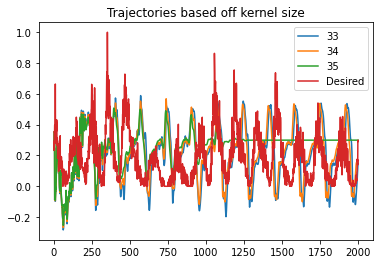

In [10]:
### DELETE LATER ###
data = np.loadtxt("sun_spot_input.asc")
#series = np.array(data)
data = (data-min(data))/(max(data)-min(data))
x = data[0:200]
d = np.roll(x, 1)[0:200]

regularizer = 0.001
embedding_size = 6
kernel_size = 1
entropy_kernel_size = [33, 34, 35]
threshold = 0.0001
forgetting_factor = 0.98
step_size = 0.2

#J3, y3, growth3, a3 = QKLMS_MCC(x[0:1100], d[0:1100], kernel_size, entropy_kernel_size, embedding_size, step_size, threshold)
for i in entropy_kernel_size :
    J, y, growth, a = QKRLS_MCC(x, d, regularizer, forgetting_factor, kernel_size, i, embedding_size, threshold)
    y1, stop_time = GenerateTrajectory(x[0:6], np.roll(data,1)[0:2000], a, kernel_size, embedding_size, 2000)
    #hist1 = plt.hist(J, bins = 100, histtype='step')
    plt.plot(y1, label=str(i))
plt.plot(data[0:2000], label="Desired")
plt.title("Trajectories based off kernel size")
plt.legend()
plt.show()
#J2, y2, growth2, a2 = QKRLS_MSE(x[0:1100], d[0:1100], regularizer, kernel_size, embedding_size, threshold)
#y1 = KernelFilter(x[0:250], a, kernel_size, embedding_size)
#y1, stop_time = GenerateTrajectory(y[0:6], d, a, kernel_size, embedding_size, 200)
### DELETE LATER ###

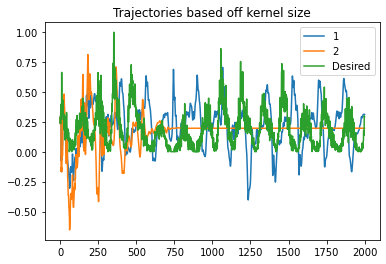

In [11]:
regularizer = 1
embedding_size = 6
kernel_size = [1, 2]
threshold = 0.0001
forgetting_factor = 0.98

for i in kernel_size :
    J2, y, growth2, a2 = QKRLS_MSE(x, d, regularizer, i, embedding_size, threshold)
    y1, stop_time = GenerateTrajectory(x[0:6], np.roll(data,1)[0:2000], a2, i, embedding_size, 2000)
    plt.plot(y1, label=str(i))
plt.plot(data[0:2000], label="Desired")
plt.title("Trajectories based off kernel size")
plt.legend()
plt.show()

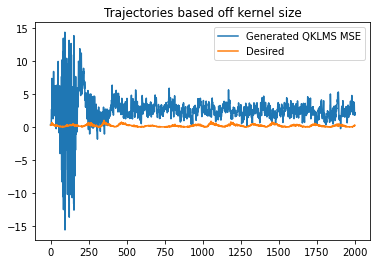

In [45]:
regularizer = 0.001
embedding_size = 6
kernel_size = 10
entropy_kernel_size = 1
threshold = 0.0001
forgetting_factor = 0.98
step_size = 2
J, y, growth, a = QKRLS_MCC(x, d, regularizer, forgetting_factor, kernel_size, entropy_kernel_size, embedding_size, threshold)
J2, y, growth2, a2 = QKRLS_MSE(x, d, .5, kernel_size, embedding_size, threshold)
J3, y, growth3, a3 = QKLMS_MCC(x, d, kernel_size, entropy_kernel_size, embedding_size, step_size, threshold)
J4, y, growth4, a4 = QKLMS_MSE(x, d, kernel_size, embedding_size, step_size, threshold)

y_klms1 = np.zeros(2000)
y_klms2 = np.zeros(2000)
y_krls1 = np.zeros(2000)
y_krls2 = np.zeros(2000)
for i in range(20) :
    #y1, stop_time = GenerateTrajectory(x[i:i+6], np.roll(data,1)[0:2000], a, kernel_size, embedding_size, 2000)
    #y2, stop_time = GenerateTrajectory(x[i:i+6], np.roll(data,1)[0:2000], a2, kernel_size, embedding_size, 2000)
    #y3, stop_time = GenerateTrajectory(x[i:i+6], np.roll(data,1)[0:2000], a3, kernel_size, embedding_size, 2000)
    y4, stop_time = GenerateTrajectory(x[i:i+6], np.roll(data,1)[0:2000], a4, kernel_size, embedding_size, 2000)
    #y_krls1 = np.add(y_krls1, y1)
    #y_krls2 = np.add(y_krls2, y2)
    y_klms1 = np.add(y_klms1, y4)
    #y_klms2 = np.add(y_klms2, y3)
#plt.plot(y_krls1/20, label="Generated QKRLS MCC")
#plt.plot(y_krls2/20, label="Generated QKRLS MSE")
plt.plot(y_klms1/20, label="Generated QKLMS MSE")
#plt.plot(y_klms2/20, label="Generated QKLMS MCC")
plt.plot(data[1:2001], label="Desired")
plt.title("Trajectories based off kernel size")
plt.legend()
plt.show()